# 1. Set up Environment

In [ ]:
! pip install --quiet underthesea
! pip install --quiet vncorenlp
! pip install --quiet py_vncorenlp
! pip install --quiet python-rdrsegmenter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
# see data preprocessing steps at link:
# https://colab.research.google.com/drive/1AuvWD-Lo6UIjyb_fmjxGB1zLZWZQ7GFf?ouid=115125045212634117084&usp=drive_link

from data_preprocessing import *

import numpy as np
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from underthesea import word_tokenize, text_normalize
from gensim.models import word2vec
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP

# 2. Read data

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/THESIS DSEB62: Product review analysis/Joined Data/final_data.xlsx")

def relabel(label):
    if label != 0:
        return 1
    else:
        return 0

data = data.fillna(0)
data["Quality"] =  data["Quality"].apply(lambda x: relabel(x))
data["Serve"] =  data["Serve"].apply(lambda x: relabel(x))
data["Quality"] =  data["Quality"].apply(lambda x: relabel(x))
data["Pack"] =  data["Pack"].apply(lambda x: relabel(x))
data["Shipping"] =  data["Shipping"].apply(lambda x: relabel(x))

df = data.copy()
df["comment"] = df["comment"].apply(lambda x: cleaning(x))


# 3. Training the Word2vec model for embedding

## 3.1 Embedding the corpus

In [ ]:
# Create tokenized corpora
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/transformers/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')
corpora = df["comment"].values
tokenized = [rdrsegmenter.tokenize(corpus)[0] for corpus in corpora]

In [ ]:
vs = 150 # number of dimensions that our words are going to be embedded in
context_size = 5 # context window
min_word = 10 # minimal number of occurence to be included in the embedded corpus
sg = 1 # embedding method (0: CBOW, 1: Skip-gram)

word_vec= word2vec.Word2Vec(tokenized, vector_size = vs, \
                            window=context_size, min_count=min_word, \
                            epochs=50, seed=42, sg = sg)

## 3.2 Visualize the embedded words

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def hierarchical_clustering(model, n):
  """ A function to plot and display the hierarchical clustering from the embedded words
  Parameters
  ----------
  model : str
  trained word2vec model

  """
  # Perform hierarchical clustering
  linkage_matrix = linkage(model.wv.vectors[0:n], method='complete', metric='seuclidean')

  # Create a dendrogram plot
  plt.figure(figsize=(7, 7))
  plt.title('Hierarchical Clustering Dendrogram')

  # Add axis labels
  plt.ylabel('word')
  plt.xlabel('distance')

  # Plot the dendrogram
  dendrogram(
      linkage_matrix,
      leaf_rotation=0.,
      leaf_font_size=8.,
      orientation='left',
      leaf_label_func=lambda v: str(model.wv.index_to_key[v])
  )

  # Show the plot
  plt.show()


# Silence warning
np.set_printoptions(suppress=True)

def display_tsne_scatterplot(model, words=None, sample=0, perplexity =  3):
  """ A function to plot and display the scatter plot of our word embedding model after T-SNE dimensional reduction
  Parameters
  ----------
  model : str
  trained word2vec model

  words: list
  list of words to display (display random words if None)

  sample: int
  number of words to include in the plot

  perplexity: int
  perplexity for T-SNE dimensional reduction
  """
  # Create corpus of words included in the model
  words = list(set(words).intersection(set(model.wv.index_to_key )))

  # Choosing words to include in the visualization
  if words == None:
      if sample > 0:
          words = np.random.choice(list(model.vocab.keys()), sample)
      else:
          words = [ word for word in model.wv.index_to_key  ]
          words = random.choices(words, k=40)
  word_vectors = np.array([model.wv[w] for w in words])

  # Dimensional reduction
  twodim = TSNE(perplexity=perplexity).fit_transform(word_vectors)

  # Plot
  plt.figure()
  plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
  for word, (x,y) in zip(words, twodim):
      plt.text(x+0.05, y+0.05, word)
  plt.show()

In [ ]:
print("Top 10 most similar words to 'giao' ")
print(word_vec.wv.most_similar("giao"))
print("Top 10 most similar words to 'dịch_vụ' ")
print(word_vec.wv.most_similar("dịch_vụ"))
print("Top 10 most similar words to 'chất_lượng' ")
print(word_vec.wv.most_similar("chất_lượng"))
print("Top 10 most similar words to 'đóng_gói' ")
print(word_vec.wv.most_similar("đóng_gói"))

Top 10 most similar words to 'giao' 
[('hàng', 0.6039029955863953), ('đúng', 0.46488696336746216), ('đẹp', 0.4612096846103668), ('nhanh', 0.4610040783882141), ('đóng_gói', 0.4490237236022949), ('giáo', 0.44106996059417725), ('chuẩn_bị', 0.4206833839416504), ('chất_lượng', 0.41551482677459717), ('cẩn_thận', 0.41521093249320984), ('toots', 0.4144323468208313)]
Top 10 most similar words to 'dịch_vụ' 
[('samsung', 0.41361889243125916), ('chăm_sóc', 0.3957105875015259), ('vận_chuyển', 0.37419962882995605), ('việc', 0.372322678565979), ('yêu_cầu', 0.36432793736457825), ('vô_trách_nhiệm', 0.3639320433139801), ('nhận_xét', 0.3552205562591553), ('thái_độ', 0.3525346517562866), ('tồi', 0.35002195835113525), ('khách_hàng', 0.34773796796798706)]
Top 10 most similar words to 'chất_lượng' 
[('sản_phẩm', 0.6821520328521729), ('tốt', 0.5664994120597839), ('toots', 0.5467351675033569), ('đúng', 0.5132519602775574), ('đóng_gói', 0.48235416412353516), ('mô_tả', 0.47113627195358276), ('với', 0.43594634532

Chất lượng sản phẩm:bình thường
Đúng với mô tả:sai mô tả

Đặt 3 cuộn màu trắng thì giao 2 cuộn mau xanh, chẳng hiểu luôn, giao mà ko thấy nói gì, lần này cho tạm 3 sao


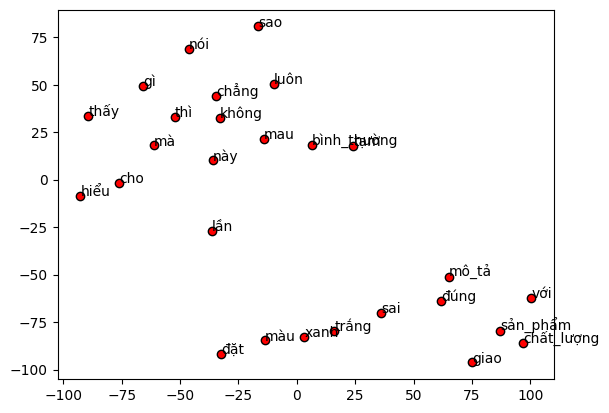

In [ ]:
print(data["comment"].iloc[81])
display_tsne_scatterplot(word_vec, words = tokenized[81])

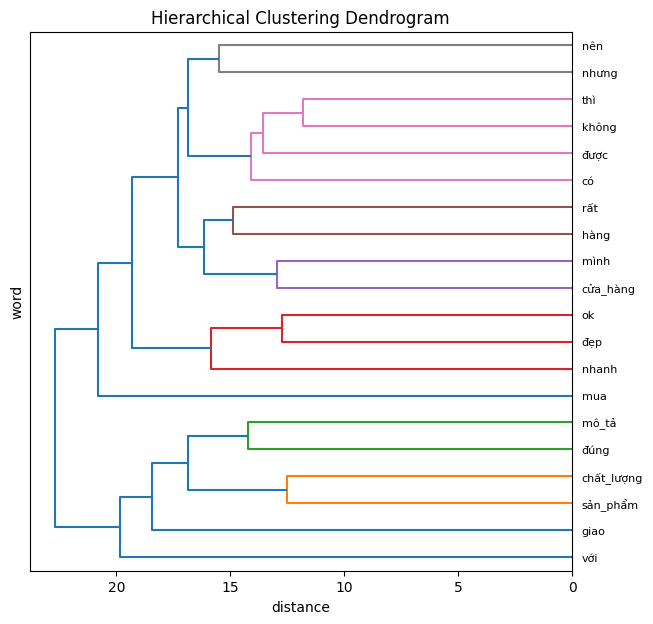

In [ ]:
hierarchical_clustering(word_vec, 20)

# 4. Modelling

## 4.1 Feature engineer

In [ ]:
# Get words and indexes from the word2vec model
word_vec_unpack = [(word, idx) for word, idx in \
                   word_vec.wv.key_to_index.items()]
tokens, indexes = zip(*word_vec_unpack)

In [ ]:
# Create dataframe with words as index and their embedded features as columns
word_vec_df = pd.DataFrame(word_vec.wv.vectors[indexes, :], index=tokens)

word_vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
không,-0.426453,-0.316964,1.263453,-0.027674,-1.036428,1.140890,-0.193544,0.607133,-0.875097,0.096208,...,0.552033,-0.888699,-1.157712,-0.282474,0.789906,-0.518229,-0.628826,-0.207910,0.758035,-0.424243
hàng,-0.482339,1.242040,0.450030,1.289863,0.870148,0.076508,0.691660,0.791631,0.194233,0.078921,...,0.533607,0.703288,-0.732312,1.187697,-0.074418,0.098712,0.907454,2.226620,0.380007,-0.409147
giao,-0.172992,1.717131,-1.035432,0.628790,0.338118,-1.470353,-0.506170,-0.840080,0.375753,-1.835866,...,0.196710,-0.655573,-0.929927,0.338147,-0.382326,-0.006687,0.365310,0.561880,0.610340,0.222718
đúng,-2.271198,2.068687,0.102317,-0.131916,0.204658,-2.161139,-0.900059,-1.065786,1.682495,-0.212130,...,0.727440,1.566126,-1.659622,1.043685,0.963339,0.468430,1.537798,0.400262,1.560099,-0.362132
cửa_hàng,1.066170,0.423711,0.050009,0.585872,1.800798,0.147606,-0.736479,1.610434,0.268917,0.340080,...,0.153074,0.377207,-1.239550,-0.845381,0.670131,0.706016,-0.592832,1.441972,-0.961707,-0.757882


In [ ]:
tokenized_array = np.array(tokenized)
# Features for the model (for each feature, calculate the average of the value corresponding to the words in the sentence)
model_array = np.array([word_vec_df.loc[list(set(doc).intersection(set(word_vec_df.index)))].mean(axis=0) for doc in tokenized_array ])

<ipython-input-30-4d3a42bba136>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tokenized_array = np.array(tokenized)


In [ ]:
# Features dataframe with sentences as index and features as columns
model_df = pd.DataFrame(model_array)

model_df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.090388,1.161215,-0.321878,0.930360,0.070147,0.165510,-0.493988,0.390784,0.163281,-0.988707,...,0.510642,-0.311632,-0.617331,0.307869,0.087394,0.049503,0.674651,0.578440,0.187795,0.005511
1,-1.099742,0.804125,-0.118696,0.590347,0.443060,-0.412891,-0.352772,-0.356723,0.450235,-1.010843,...,0.153821,-0.033776,-0.664007,0.417594,0.041612,-0.044390,0.254789,0.611947,0.411650,0.158732
2,-0.434938,0.286451,0.056369,-0.383519,0.698423,0.121593,-0.038834,-0.352982,0.364303,-0.264348,...,0.243652,0.176758,0.346750,0.604652,-0.629206,-1.017482,-0.194352,0.382972,0.699568,0.621021
3,-0.620161,0.729638,-0.567258,0.717916,0.123927,0.208628,0.237719,0.068288,-0.047839,-0.431837,...,0.591986,-0.161556,0.119911,0.177815,-0.340024,-0.330490,0.224737,0.787773,0.061756,-0.077835
4,-0.283085,0.062498,-0.042720,0.130919,-0.332887,-0.720463,0.289911,-0.230559,0.225763,0.151458,...,0.105762,-0.126540,-0.756563,0.063176,0.355599,-0.240759,0.362679,0.007921,0.179263,0.144484


## 4.1 Train model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(model_df, df[["Quality", "Pack", "Serve", "Shipping"]], test_size= 0.2, random_state= 60)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

xgbc = XGBClassifier(max_depth=7, n_estimators=300, objective="binary:logistic", random_state=1)

In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.multioutput import MultiOutputClassifier
clf = MultiOutputClassifier(xgbc).fit(X_train, y_train)
prediction = clf.predict(X_test)

In [ ]:
label_cols = ["Quality", "Pack", "Serve", "Shipping"]
print("Classification report from W2V + XGB model")
print('Hamming Loss: ', round(hamming_loss(y_test, prediction),2))
for i in range(len(label_cols)):
  print(f"classification report of {label_cols[i]}")
  print(classification_report(y_test[label_cols[i]], prediction[:, i]))

Classification report from W2V + XGB model
Hamming Loss:  0.11
classification report of Quality
              precision    recall  f1-score   support

           0       0.71      0.37      0.49       586
           1       0.87      0.96      0.91      2501

    accuracy                           0.85      3087
   macro avg       0.79      0.67      0.70      3087
weighted avg       0.84      0.85      0.83      3087

classification report of Pack
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2476
           1       0.92      0.77      0.83       611

    accuracy                           0.94      3087
   macro avg       0.93      0.87      0.90      3087
weighted avg       0.94      0.94      0.94      3087

classification report of Serve
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2442
           1       0.83      0.62      0.71       645

    accuracy             